# Wilcoxon Signed Rank Test: MCMC vs Standard Sampling on MATH 500

This notebook performs a comprehensive statistical analysis comparing MCMC power sampling against standard sampling for mathematical reasoning tasks. We analyze:

1. **Data Collection**: Detailed extraction of answers, reasoning steps, tokens, and log-probabilities
2. **Wilcoxon Signed Rank Test**: Non-parametric paired comparison of log-probabilities
3. **Statistical Power Analysis**: Type I error, Type II error, and power simulations
4. **Effect Size Analysis**: Understanding practical significance of differences

## Background: Wilcoxon Signed Rank Test

The Wilcoxon signed-rank test is a non-parametric statistical hypothesis test used to compare two related samples (paired observations). It's particularly useful when:
- Data is paired (same questions answered by both methods)
- Distribution may not be normal
- We want to test if median differences are zero

**Null Hypothesis (H₀)**: The median difference in log-probabilities between MCMC and standard sampling is zero

**Alternative Hypothesis (H₁)**: The median difference is not zero (two-tailed) or MCMC > Standard (one-tailed)

In [3]:
# Import required libraries
import os
import sys
import json
import random
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Statistical tests
from scipy import stats
from scipy.stats import wilcoxon, shapiro, normaltest

# PyTorch for model inference
import torch
import torch.nn.functional as F
import transformers

# Add project path to sys.path
project_root = Path('/home/wliu23/github/reasoning-with-sampling/llm_experiments')
sys.path.insert(0, str(project_root))

from grader_utils.parse_utils import parse_answer
from constants import *
from power_samp_utils import AutoregressiveSampler, mcmc_power_samp, format_prompt

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Configuration and Setup

In [4]:
HF_HOME = Path("/home/wliu23/projects/reasoning-with-sampling/.hf_home")
os.environ["HF_HOME"] = str(HF_HOME)
os.environ["HF_HUB_CACHE"] = str(HF_HOME / "hub")
os.environ["TRANSFORMERS_CACHE"] = str(HF_HOME / "hub")
# optional, but keeps everything together
os.environ["HF_DATASETS_CACHE"] = str(HF_HOME / "datasets")
os.environ["HF_HUB_OFFLINE"] = "1"  # drop if you still want network fallbacks

In [5]:
import os
# Experiment Configuration
CONFIG = {
    'model': 'qwen_math',  # Options: qwen, qwen_math, phi, tulu
    'model_str': 'Qwen/Qwen2.5-Math-7B',
    'cache_dir': os.environ['TRANSFORMERS_CACHE'],
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'dataset': 'MATH',
    'dataset_path': '/home/wliu23/github/reasoning-with-sampling/llm_experiments/data/MATH500.json',
    'temperature': 0.25,
    'mcmc_steps': 10,
    'max_new_tokens': 3072,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_questions': 20,  # Start with small subset for testing; increase for full analysis
    'cot': True,
    'save_dir': '/home/wliu23/github/reasoning-with-sampling/notebooks/results',
    'alpha': 0.05,  # Significance level for statistical tests
}

# Create save directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

print(f"Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  model: qwen_math
  model_str: Qwen/Qwen2.5-Math-7B
  cache_dir: /home/wliu23/projects/reasoning-with-sampling/.hf_home/hub
  device: cuda
  dataset: MATH
  dataset_path: /home/wliu23/github/reasoning-with-sampling/llm_experiments/data/MATH500.json
  temperature: 0.25
  mcmc_steps: 10
  max_new_tokens: 3072
  num_questions: 20
  cot: True
  save_dir: /home/wliu23/github/reasoning-with-sampling/notebooks/results
  alpha: 0.05


## 2. Load Model and Dataset

In [6]:
# Load dataset
with open(CONFIG['dataset_path'], 'r') as f:
    dataset = json.load(f)

print(f"Loaded {len(dataset)} problems from MATH500 dataset")
print(f"Will process {CONFIG['num_questions']} questions for this analysis")

Loaded 500 problems from MATH500 dataset
Will process 20 questions for this analysis


In [7]:
# Load model and tokenizer
print(f"Loading model: {CONFIG['model_str']}")

tokenizer = transformers.AutoTokenizer.from_pretrained(
    CONFIG['model_str'],
    cache_dir=CONFIG['cache_dir'],
    local_files_only=True,
    trust_remote_code=True,
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    CONFIG['model_str'],
    cache_dir=CONFIG['cache_dir'],
    local_files_only=True,
    torch_dtype=torch.bfloat16,
    device_map={'': CONFIG['device']},  # or "auto" if you want HF to shard
    trust_remote_code=True,
).to(CONFIG['device'])


autoreg_sampler = AutoregressiveSampler(model, tokenizer, CONFIG['device'])

print(f"Model loaded successfully on {CONFIG['device']}")

Loading model: Qwen/Qwen2.5-Math-7B


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded successfully on cuda


## 3. Data Collection Functions

These functions collect detailed information about each generation including:
- Full completion text
- Parsed answer
- Token IDs and decoded tokens
- Individual token log-probabilities
- Cumulative log-probability
- Number of tokens generated

In [8]:
def extract_token_logprobs(output, input_length: int, tokenizer) -> Tuple[List[float], List[str]]:
    """
    Extract per-token log probabilities and tokens from model output.

    Args:
        output: Model generation output with scores
        input_length: Length of input tokens to skip
        tokenizer: Tokenizer for decoding

    Returns:
        Tuple of (log_probs, tokens)
    """
    generated_ids = output.sequences[0][input_length:]
    scores = output.scores  # List of tensors, one per generated token

    log_probs = []
    tokens = []

    for i, token_id in enumerate(generated_ids):
        if i < len(scores):
            # Get log probabilities for this position
            logits = scores[i][0]  # First batch element
            log_prob_dist = F.log_softmax(logits, dim=-1)
            token_log_prob = log_prob_dist[token_id].item()
            log_probs.append(token_log_prob)

        # Decode token
        token_text = tokenizer.decode([token_id])
        tokens.append(token_text)

    return log_probs, tokens


def generate_standard(model, tokenizer, input_ids, device, max_new_tokens=3072) -> Dict:
    """
    Generate using standard sampling (temperature=1.0).

    Returns:
        Dictionary with completion, answer, tokens, log_probs, and statistics
    """
    output = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        return_dict_in_generate=True,
        output_scores=True,
        do_sample=True,
        temperature=1.0,
    )

    # Extract tokens and log probs
    generated_ids = output.sequences[0][len(input_ids[0]):]
    completion = tokenizer.decode(generated_ids, skip_special_tokens=True)
    parsed_answer = parse_answer(completion)

    # Get detailed token information
    log_probs, tokens = extract_token_logprobs(output, len(input_ids[0]), tokenizer)

    return {
        'completion': completion,
        'answer': parsed_answer,
        'tokens': tokens,
        'token_ids': generated_ids.cpu().tolist(),
        'log_probs': log_probs,
        'cumulative_log_prob': sum(log_probs) if log_probs else 0.0,
        'num_tokens': len(tokens),
        'mean_log_prob': np.mean(log_probs) if log_probs else 0.0,
    }


def generate_mcmc(autoreg_sampler, prefix, temp, mcmc_steps, max_new_tokens=3072) -> Dict:
    """
    Generate using MCMC power sampling.

    Returns:
        Dictionary with completion, answer, tokens, log_probs, and statistics
    """
    token_ids, log_probs_norm, log_probs_unnorm, acceptance_ratio = mcmc_power_samp(
        autoreg_sampler, prefix, temp, mcmc_steps, max_new_tokens
    )

    # Remove prefix from token_ids to get only generated tokens
    generated_ids = token_ids[len(prefix):]

    # Decode tokens
    completion = autoreg_sampler.tokenizer.decode(
        generated_ids, skip_special_tokens=True
    )
    parsed_answer = parse_answer(completion)

    # Decode individual tokens
    tokens = [autoreg_sampler.tokenizer.decode([tid]) for tid in generated_ids]

    return {
        'completion': completion,
        'answer': parsed_answer,
        'tokens': tokens,
        'token_ids': generated_ids,
        'log_probs': log_probs_unnorm,  # Use unnormalized (target distribution) log probs
        'log_probs_proposal': log_probs_norm,  # Proposal distribution log probs
        'cumulative_log_prob': sum(log_probs_unnorm) if log_probs_unnorm else 0.0,
        'num_tokens': len(tokens),
        'mean_log_prob': np.mean(log_probs_unnorm) if log_probs_unnorm else 0.0,
        'acceptance_ratio': acceptance_ratio,
    }


def split_into_steps(completion: str) -> List[str]:
    """
    Split completion into reasoning steps.

    Simple heuristic: split by newlines and filter empty lines.
    For more sophisticated parsing, could use regex or model-specific patterns.
    """
    steps = [line.strip() for line in completion.split('\n') if line.strip()]
    return steps

## 4. Run Experiments and Collect Data

In [9]:
# Data collection
results = []

# Process subset of questions
questions_to_process = dataset[:CONFIG['num_questions']]

for idx, data in enumerate(tqdm(questions_to_process, desc="Processing MATH problems")):
    question = data['prompt']
    correct_answer = data['answer']

    print(f"\n{'='*80}")
    print(f"Question {idx+1}/{len(questions_to_process)}")
    print(f"{'='*80}")
    print(f"Q: {question[:100]}...")

    # Prepare input
    input_text = format_prompt(question, CONFIG['model'], tokenizer, CONFIG['cot'])
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(CONFIG['device'])
    prefix = [idx.item() for idx in input_ids[0]]

    # Standard sampling
    print("\n[Standard Sampling]")
    std_result = generate_standard(
        model, tokenizer, input_ids, CONFIG['device'], CONFIG['max_new_tokens']
    )
    print(f"  Answer: {std_result['answer']}")
    print(f"  Tokens: {std_result['num_tokens']}")
    print(f"  Cumulative log-prob: {std_result['cumulative_log_prob']:.4f}")

    # MCMC sampling
    print("\n[MCMC Sampling]")
    mcmc_result = generate_mcmc(
        autoreg_sampler, prefix, CONFIG['temperature'],
        CONFIG['mcmc_steps'], CONFIG['max_new_tokens']
    )
    print(f"  Answer: {mcmc_result['answer']}")
    print(f"  Tokens: {mcmc_result['num_tokens']}")
    print(f"  Cumulative log-prob: {mcmc_result['cumulative_log_prob']:.4f}")
    print(f"  Acceptance ratio: {mcmc_result['acceptance_ratio']:.4f}")

    # Store results
    results.append({
        'question_idx': idx,
        'question': question,
        'correct_answer': correct_answer,

        # Standard sampling results
        'std_completion': std_result['completion'],
        'std_answer': std_result['answer'],
        'std_steps': split_into_steps(std_result['completion']),
        'std_tokens': std_result['tokens'],
        'std_token_ids': std_result['token_ids'],
        'std_log_probs': std_result['log_probs'],
        'std_cumulative_log_prob': std_result['cumulative_log_prob'],
        'std_num_tokens': std_result['num_tokens'],
        'std_mean_log_prob': std_result['mean_log_prob'],
        'std_correct': std_result['answer'] == correct_answer,

        # MCMC sampling results
        'mcmc_completion': mcmc_result['completion'],
        'mcmc_answer': mcmc_result['answer'],
        'mcmc_steps': split_into_steps(mcmc_result['completion']),
        'mcmc_tokens': mcmc_result['tokens'],
        'mcmc_token_ids': mcmc_result['token_ids'],
        'mcmc_log_probs': mcmc_result['log_probs'],
        'mcmc_log_probs_proposal': mcmc_result['log_probs_proposal'],
        'mcmc_cumulative_log_prob': mcmc_result['cumulative_log_prob'],
        'mcmc_num_tokens': mcmc_result['num_tokens'],
        'mcmc_mean_log_prob': mcmc_result['mean_log_prob'],
        'mcmc_acceptance_ratio': mcmc_result['acceptance_ratio'],
        'mcmc_correct': mcmc_result['answer'] == correct_answer,
    })

print(f"\n\nCompleted data collection for {len(results)} questions")

Processing MATH problems:   0%|          | 0/20 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Question 1/20
Q: Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the...

[Standard Sampling]
  Answer: \left(3, \frac{\pi}{2}\right)
  Tokens: 476
  Cumulative log-prob: -47.3174

[MCMC Sampling]
alpha: 4.0
3072
192











100%|██████████| 10/10 [00:10<00:00,  1.02s/it]










100%|██████████| 10/10 [00:19<00:00,  1.94s/it]











100%|██████████| 10/10 [00:13<00:00,  1.37s/it]











 19%|█▉        | 3/16 [01:03<04:36, 21.24s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: (3, \frac{\pi}{2})
  Tokens: 332
  Cumulative log-prob: -50.3851
  Acceptance ratio: 0.5000

Question 2/20
Q: Define
\[p = \sum_{k = 1}^\infty \frac{1}{k^2} \quad \text{and} \quad q = \sum_{k = 1}^\infty \frac{...

[Standard Sampling]
  Answer: q
  Tokens: 1219
  Cumulative log-prob: -778.8274

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:11<00:00,  1.15s/it]











100%|██████████| 10/10 [00:19<00:00,  1.94s/it]











100%|██████████| 10/10 [00:34<00:00,  3.50s/it]











100%|██████████| 10/10 [00:28<00:00,  2.81s/it]











100%|██████████| 10/10 [00:32<00:00,  3.21s/it]











 31%|███▏      | 5/16 [02:39<05:51, 31.95s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: p - q
  Tokens: 909
  Cumulative log-prob: -167.1362
  Acceptance ratio: 0.3167

Question 3/20
Q: If $f(x) = \frac{3x-2}{x-2}$, what is the value of $f(-2) +f(-1)+f(0)$? Express your answer as a com...

[Standard Sampling]
  Answer: None
  Tokens: 439
  Cumulative log-prob: -95.7396

[MCMC Sampling]
alpha: 4.0
3072
192












100%|██████████| 10/10 [00:11<00:00,  1.11s/it]











100%|██████████| 10/10 [00:18<00:00,  1.81s/it]











 12%|█▎        | 2/16 [00:52<06:07, 26.28s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: \frac{14}{3}
  Tokens: 486
  Cumulative log-prob: -27.5231
  Acceptance ratio: 0.8000

Question 4/20
Q: How many positive whole-number divisors does 196 have?...

[Standard Sampling]
  Answer: 9
  Tokens: 210
  Cumulative log-prob: -68.3530

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:11<00:00,  1.19s/it]











100%|██████████| 10/10 [00:14<00:00,  1.50s/it]










100%|██████████| 10/10 [00:23<00:00,  2.33s/it]











 19%|█▉        | 3/16 [01:18<05:38, 26.04s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 9
  Tokens: 551
  Cumulative log-prob: -33.9746
  Acceptance ratio: 0.6750

Question 5/20
Q: The results of a cross-country team's training run are graphed below. Which student has the greatest...

[Standard Sampling]
  Answer: \text{Evelyn}
  Tokens: 475
  Cumulative log-prob: -142.3823

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.02it/s]











100%|██████████| 10/10 [00:24<00:00,  2.42s/it]











100%|██████████| 10/10 [00:23<00:00,  2.35s/it]











 19%|█▉        | 3/16 [01:24<06:06, 28.19s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: \text{Evelyn}
  Tokens: 467
  Cumulative log-prob: -77.9969
  Acceptance ratio: 0.4500

Question 6/20
Q: A regular hexagon can be divided into six equilateral triangles. If the perimeter of one of the tria...

[Standard Sampling]
  Answer: 42
  Tokens: 184
  Cumulative log-prob: -45.3603

[MCMC Sampling]
alpha: 4.0
3072
192











100%|██████████| 10/10 [00:05<00:00,  1.86it/s]










  6%|▋         | 1/16 [00:22<05:38, 22.56s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 42
  Tokens: 306
  Cumulative log-prob: -43.8888
  Acceptance ratio: 0.7000

Question 7/20
Q: What is the smallest positive perfect cube that can be written as the sum of three consecutive integ...

[Standard Sampling]
  Answer: 27
  Tokens: 388
  Cumulative log-prob: -19.6938

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:10<00:00,  1.00s/it]











100%|██████████| 10/10 [00:21<00:00,  2.20s/it]











 12%|█▎        | 2/16 [00:52<06:09, 26.42s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 27
  Tokens: 449
  Cumulative log-prob: -42.1424
  Acceptance ratio: 0.6333

Question 8/20
Q: The set of points $(x,y,z)$ that satisfy
\[2x = 3y = -z\]is a line.

The set of points $(x,y,z)$ tha...

[Standard Sampling]
  Answer: None
  Tokens: 457
  Cumulative log-prob: -75.2678

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.05it/s]











100%|██████████| 10/10 [00:14<00:00,  1.49s/it]











100%|██████████| 10/10 [00:27<00:00,  2.76s/it]










 19%|█▉        | 3/16 [01:31<06:38, 30.65s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 116.57
  Tokens: 672
  Cumulative log-prob: -119.9755
  Acceptance ratio: 0.5500

Question 9/20
Q: What is the distance, in units, between the points $(2, -6)$ and $(-4, 3)$? Express your answer in s...

[Standard Sampling]
  Answer: 3\sqrt{13}
  Tokens: 396
  Cumulative log-prob: -4.5874

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:11<00:00,  1.15s/it]










  6%|▋         | 1/16 [00:29<07:19, 29.29s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 3\sqrt{13}
  Tokens: 382
  Cumulative log-prob: -18.6251
  Acceptance ratio: 0.8500

Question 10/20
Q: The expression $2\cdot 3 \cdot 4\cdot 5+1$ is equal to 121, since multiplication is carried out befo...

[Standard Sampling]
  Answer: 3
  Tokens: 1001
  Cumulative log-prob: -124.6565

[MCMC Sampling]
alpha: 4.0
3072
192











100%|██████████| 10/10 [00:08<00:00,  1.21it/s]










100%|██████████| 10/10 [00:17<00:00,  1.75s/it]











100%|██████████| 10/10 [00:35<00:00,  3.53s/it]











100%|██████████| 10/10 [00:28<00:00,  2.86s/it]











 25%|██▌       | 4/16 [02:08<06:25, 32.12s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 3
  Tokens: 756
  Cumulative log-prob: -200.4963
  Acceptance ratio: 0.4600

Question 11/20
Q: What is the least positive integer multiple of 30 that can be written with only the digits 0 and 2?...

[Standard Sampling]
  Answer: None
  Tokens: 215
  Cumulative log-prob: -50.6646

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.03it/s]











  6%|▋         | 1/16 [00:33<08:16, 33.10s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 2220
  Tokens: 381
  Cumulative log-prob: -58.0016
  Acceptance ratio: 0.5000

Question 12/20
Q: Let $p(x)$ be a polynomial of degree 5 such that
\[p(n) = \frac{n}{n^2 - 1}\]for $n = 2,$ 3, 4, $\do...

[Standard Sampling]
  Answer: 3120
  Tokens: 398
  Cumulative log-prob: -230.9602

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.10it/s]











100%|██████████| 10/10 [00:17<00:00,  1.74s/it]











100%|██████████| 10/10 [00:29<00:00,  2.99s/it]











100%|██████████| 10/10 [00:44<00:00,  4.45s/it]











 25%|██▌       | 4/16 [02:29<07:27, 37.28s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: \frac{1}{6}
  Tokens: 936
  Cumulative log-prob: -179.3111
  Acceptance ratio: 0.3600

Question 13/20
Q: The proper divisors of 12 are 1, 2, 3, 4 and 6. A proper divisor of an integer $N$ is a positive div...

[Standard Sampling]
  Answer: 284
  Tokens: 831
  Cumulative log-prob: -20.1021

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:10<00:00,  1.09s/it]











100%|██████████| 10/10 [00:21<00:00,  2.18s/it]










100%|██████████| 10/10 [00:28<00:00,  2.90s/it]











100%|██████████| 10/10 [00:34<00:00,  3.45s/it]











 25%|██▌       | 4/16 [02:22<07:07, 35.60s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 284
  Tokens: 675
  Cumulative log-prob: -69.5953
  Acceptance ratio: 0.6000

Question 14/20
Q: The volume of the cylinder shown is $45\pi$ cubic cm. What is the height in centimeters of the cylin...

[Standard Sampling]
  Answer: 5
  Tokens: 366
  Cumulative log-prob: -56.4770

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.09it/s]











100%|██████████| 10/10 [00:16<00:00,  1.65s/it]










 12%|█▎        | 2/16 [00:40<04:40, 20.05s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 5
  Tokens: 318
  Cumulative log-prob: -62.4056
  Acceptance ratio: 0.4667

Question 15/20
Q: Suppose $\sin D = 0.7$ in the diagram below. What is $DE$? [asy]
pair D,E,F;
F = (0,0);
D = (sqrt(51...

[Standard Sampling]
  Answer: 10
  Tokens: 294
  Cumulative log-prob: -32.4841

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:08<00:00,  1.17it/s]











  6%|▋         | 1/16 [00:20<05:08, 20.57s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 10
  Tokens: 252
  Cumulative log-prob: -59.1055
  Acceptance ratio: 0.4000

Question 16/20
Q: Let $z = 2 + \sqrt{2} - (3 + 3 \sqrt{2})i$, and let $c = 2 - 3i$.  Let $w$ be the result when $z$ is...

[Standard Sampling]
  Answer: 2 + \sqrt{2} - 3 - 6i
  Tokens: 2894
  Cumulative log-prob: -732.6129

[MCMC Sampling]
alpha: 4.0
3072
192












100%|██████████| 10/10 [00:07<00:00,  1.39it/s]











100%|██████████| 10/10 [00:16<00:00,  1.65s/it]











100%|██████████| 10/10 [00:25<00:00,  2.50s/it]











100%|██████████| 10/10 [00:23<00:00,  2.31s/it]











 25%|██▌       | 4/16 [01:48<05:25, 27.10s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 2 + \sqrt{2} - (\sqrt{2} + 3)i
  Tokens: 603
  Cumulative log-prob: -163.4338
  Acceptance ratio: 0.5000

Question 17/20
Q: Compute: $1-2+3-4+5- \dots +99-100$....

[Standard Sampling]
  Answer: None
  Tokens: 284
  Cumulative log-prob: -170.6071

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:08<00:00,  1.18it/s]











100%|██████████| 10/10 [00:15<00:00,  1.52s/it]











100%|██████████| 10/10 [00:14<00:00,  1.50s/it]











 19%|█▉        | 3/16 [00:52<03:49, 17.65s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: -50
  Tokens: 307
  Cumulative log-prob: -30.7392
  Acceptance ratio: 0.7250

Question 18/20
Q: Below is the graph of $y = a \sin (bx + c) + d$ for some positive constants $a,$ $b,$ $c,$ and $d.$ ...

[Standard Sampling]
  Answer: \pi
  Tokens: 568
  Cumulative log-prob: -109.8235

[MCMC Sampling]
alpha: 4.0
3072
192












100%|██████████| 10/10 [00:06<00:00,  1.50it/s]










100%|██████████| 10/10 [00:13<00:00,  1.35s/it]










 12%|█▎        | 2/16 [00:48<05:41, 24.39s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: \pi
  Tokens: 554
  Cumulative log-prob: -170.2027
  Acceptance ratio: 0.5333

Question 19/20
Q: $\overline{BC}$ is parallel to the segment through $A$, and $AB = BC$. What is the number of degrees...

[Standard Sampling]
  Answer: 28^{\circ}
  Tokens: 328
  Cumulative log-prob: -63.1628

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:11<00:00,  1.13s/it]











100%|██████████| 10/10 [00:18<00:00,  1.85s/it]











100%|██████████| 10/10 [00:19<00:00,  1.96s/it]











 19%|█▉        | 3/16 [01:19<05:45, 26.55s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


  Answer: 28
  Tokens: 531
  Cumulative log-prob: -104.1881
  Acceptance ratio: 0.4750

Question 20/20
Q: Let $a$ be a positive real number such that all the roots of
\[x^3 + ax^2 + ax + 1 = 0\]are real.  F...

[Standard Sampling]
  Answer: 3
  Tokens: 743
  Cumulative log-prob: -95.8701

[MCMC Sampling]
alpha: 4.0
3072
192













100%|██████████| 10/10 [00:09<00:00,  1.08it/s]











100%|██████████| 10/10 [00:21<00:00,  2.12s/it]











100%|██████████| 10/10 [00:25<00:00,  2.51s/it]










100%|██████████| 10/10 [00:37<00:00,  3.78s/it]










 25%|██▌       | 4/16 [02:24<07:13, 36.16s/it]

  Answer: 3
  Tokens: 812
  Cumulative log-prob: -93.5206
  Acceptance ratio: 0.6200


Completed data collection for 20 questions


In [10]:
# Save raw results
results_file = os.path.join(CONFIG['save_dir'], 'wilcoxon_raw_results.json')
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved raw results to {results_file}")

Saved raw results to /home/wliu23/github/reasoning-with-sampling/notebooks/results/wilcoxon_raw_results.json


## 5. Exploratory Data Analysis

In [11]:
# Create summary DataFrame
summary_data = []
for r in results:
    summary_data.append({
        'question_idx': r['question_idx'],
        'std_cumulative_log_prob': r['std_cumulative_log_prob'],
        'mcmc_cumulative_log_prob': r['mcmc_cumulative_log_prob'],
        'std_mean_log_prob': r['std_mean_log_prob'],
        'mcmc_mean_log_prob': r['mcmc_mean_log_prob'],
        'std_num_tokens': r['std_num_tokens'],
        'mcmc_num_tokens': r['mcmc_num_tokens'],
        'std_correct': r['std_correct'],
        'mcmc_correct': r['mcmc_correct'],
        'mcmc_acceptance_ratio': r['mcmc_acceptance_ratio'],
    })

df_summary = pd.DataFrame(summary_data)
df_summary.head(10)

,question_idx,std_cumulative_log_prob,mcmc_cumulative_log_prob,std_mean_log_prob,mcmc_mean_log_prob,std_num_tokens,mcmc_num_tokens,std_correct,mcmc_correct,mcmc_acceptance_ratio
0,0,-47.317440,-50.385065,-0.099406,-0.151762,476,332,False,False,0.500000
1,1,-778.827373,-167.136233,-0.638907,-0.183868,1219,909,False,True,0.316667
2,2,-95.739617,-27.523140,-0.218086,-0.056632,439,486,False,True,0.800000
3,3,-68.352975,-33.974631,-0.325490,-0.061660,210,551,True,True,0.675000
4,4,-142.382279,-77.996898,-0.299752,-0.167017,475,467,True,True,0.450000
5,5,-45.360264,-43.888832,-0.246523,-0.143428,184,306,True,True,0.700000
6,6,-19.693801,-42.142355,-0.050757,-0.093858,388,449,True,True,0.633333
7,7,-75.267814,-119.975460,-0.164700,-0.178535,457,672,False,False,0.550000
8,8,-4.587428,-18.625121,-0.011584,-0.048757,396,382,True,True,0.850000
9,9,-124.656480,-200.496265,-0.124532,-0.265207,1001,756,False,False,0.460000


In [12]:
# Descriptive statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)

print("\nStandard Sampling:")
print(f"  Mean cumulative log-prob: {df_summary['std_cumulative_log_prob'].mean():.4f}")
print(f"  Std cumulative log-prob: {df_summary['std_cumulative_log_prob'].std():.4f}")
print(f"  Mean tokens: {df_summary['std_num_tokens'].mean():.2f}")
print(f"  Accuracy: {df_summary['std_correct'].mean():.2%}")

print("\nMCMC Sampling:")
print(f"  Mean cumulative log-prob: {df_summary['mcmc_cumulative_log_prob'].mean():.4f}")
print(f"  Std cumulative log-prob: {df_summary['mcmc_cumulative_log_prob'].std():.4f}")
print(f"  Mean tokens: {df_summary['mcmc_num_tokens'].mean():.2f}")
print(f"  Accuracy: {df_summary['mcmc_correct'].mean():.2%}")
print(f"  Mean acceptance ratio: {df_summary['mcmc_acceptance_ratio'].mean():.4f}")

# Calculate differences
df_summary['log_prob_diff'] = df_summary['mcmc_cumulative_log_prob'] - df_summary['std_cumulative_log_prob']
df_summary['mean_log_prob_diff'] = df_summary['mcmc_mean_log_prob'] - df_summary['std_mean_log_prob']

print("\nDifferences (MCMC - Standard):")
print(f"  Mean cumulative log-prob difference: {df_summary['log_prob_diff'].mean():.4f}")
print(f"  Std cumulative log-prob difference: {df_summary['log_prob_diff'].std():.4f}")
print(f"  Mean per-token log-prob difference: {df_summary['mean_log_prob_diff'].mean():.4f}")


DESCRIPTIVE STATISTICS

Standard Sampling:
  Mean cumulative log-prob: -148.2475
  Std cumulative log-prob: 215.0490
  Mean tokens: 608.30
  Accuracy: 45.00%

MCMC Sampling:
  Mean cumulative log-prob: -88.6324
  Std cumulative log-prob: 58.0246
  Mean tokens: 533.95
  Accuracy: 70.00%
  Mean acceptance ratio: 0.5557

Differences (MCMC - Standard):
  Mean cumulative log-prob difference: 59.6151
  Std cumulative log-prob difference: 188.6667
  Mean per-token log-prob difference: 0.0718


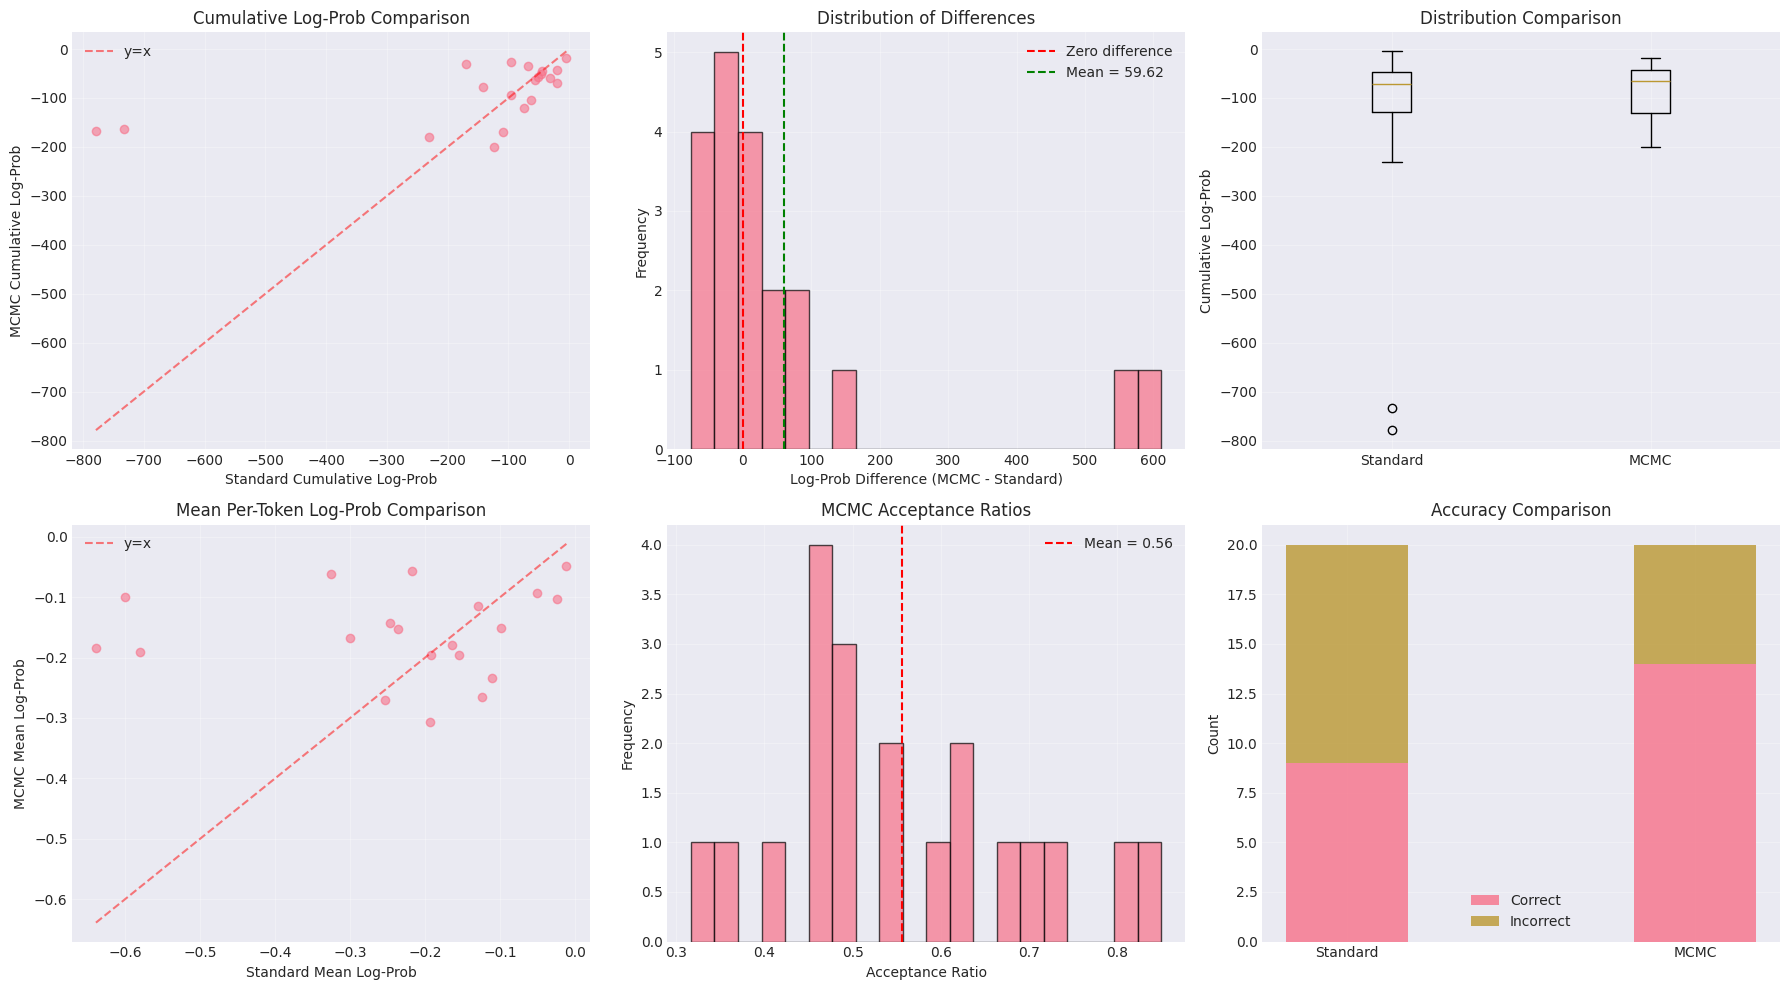

In [13]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Cumulative log-prob comparison
axes[0, 0].scatter(df_summary['std_cumulative_log_prob'],
                   df_summary['mcmc_cumulative_log_prob'], alpha=0.6)
lims = [min(df_summary['std_cumulative_log_prob'].min(), df_summary['mcmc_cumulative_log_prob'].min()),
        max(df_summary['std_cumulative_log_prob'].max(), df_summary['mcmc_cumulative_log_prob'].max())]
axes[0, 0].plot(lims, lims, 'r--', alpha=0.5, label='y=x')
axes[0, 0].set_xlabel('Standard Cumulative Log-Prob')
axes[0, 0].set_ylabel('MCMC Cumulative Log-Prob')
axes[0, 0].set_title('Cumulative Log-Prob Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of differences
axes[0, 1].hist(df_summary['log_prob_diff'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', label='Zero difference')
axes[0, 1].axvline(df_summary['log_prob_diff'].mean(), color='g',
                   linestyle='--', label=f'Mean = {df_summary["log_prob_diff"].mean():.2f}')
axes[0, 1].set_xlabel('Log-Prob Difference (MCMC - Standard)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Differences')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot comparison
box_data = [df_summary['std_cumulative_log_prob'], df_summary['mcmc_cumulative_log_prob']]
axes[0, 2].boxplot(box_data, labels=['Standard', 'MCMC'])
axes[0, 2].set_ylabel('Cumulative Log-Prob')
axes[0, 2].set_title('Distribution Comparison')
axes[0, 2].grid(True, alpha=0.3)

# 4. Mean per-token log-prob comparison
axes[1, 0].scatter(df_summary['std_mean_log_prob'],
                   df_summary['mcmc_mean_log_prob'], alpha=0.6)
lims = [min(df_summary['std_mean_log_prob'].min(), df_summary['mcmc_mean_log_prob'].min()),
        max(df_summary['std_mean_log_prob'].max(), df_summary['mcmc_mean_log_prob'].max())]
axes[1, 0].plot(lims, lims, 'r--', alpha=0.5, label='y=x')
axes[1, 0].set_xlabel('Standard Mean Log-Prob')
axes[1, 0].set_ylabel('MCMC Mean Log-Prob')
axes[1, 0].set_title('Mean Per-Token Log-Prob Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Acceptance ratio distribution
axes[1, 1].hist(df_summary['mcmc_acceptance_ratio'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_summary['mcmc_acceptance_ratio'].mean(), color='r',
                   linestyle='--', label=f'Mean = {df_summary["mcmc_acceptance_ratio"].mean():.2f}')
axes[1, 1].set_xlabel('Acceptance Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('MCMC Acceptance Ratios')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Accuracy comparison
accuracy_data = [
    ['Standard', df_summary['std_correct'].sum(), len(df_summary) - df_summary['std_correct'].sum()],
    ['MCMC', df_summary['mcmc_correct'].sum(), len(df_summary) - df_summary['mcmc_correct'].sum()]
]
methods = [x[0] for x in accuracy_data]
correct = [x[1] for x in accuracy_data]
incorrect = [x[2] for x in accuracy_data]

x = np.arange(len(methods))
width = 0.35
axes[1, 2].bar(x, correct, width, label='Correct', alpha=0.8)
axes[1, 2].bar(x, incorrect, width, bottom=correct, label='Incorrect', alpha=0.8)
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Accuracy Comparison')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(methods)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'eda_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Wilcoxon Signed Rank Test

### Test Assumptions
1. **Paired observations**: Same questions answered by both methods ✓
2. **Continuous or ordinal data**: Log-probabilities are continuous ✓
3. **Symmetric distribution of differences**: We'll check this below

### Hypotheses
- **H₀**: The median difference in cumulative log-probabilities is zero
- **H₁**: The median difference is not zero (two-tailed)


TESTING ASSUMPTIONS

Shapiro-Wilk Test for Normality of Differences:
  Test statistic: 0.5972
  p-value: 0.0000
  → Reject normality (p < 0.05): Wilcoxon test is appropriate


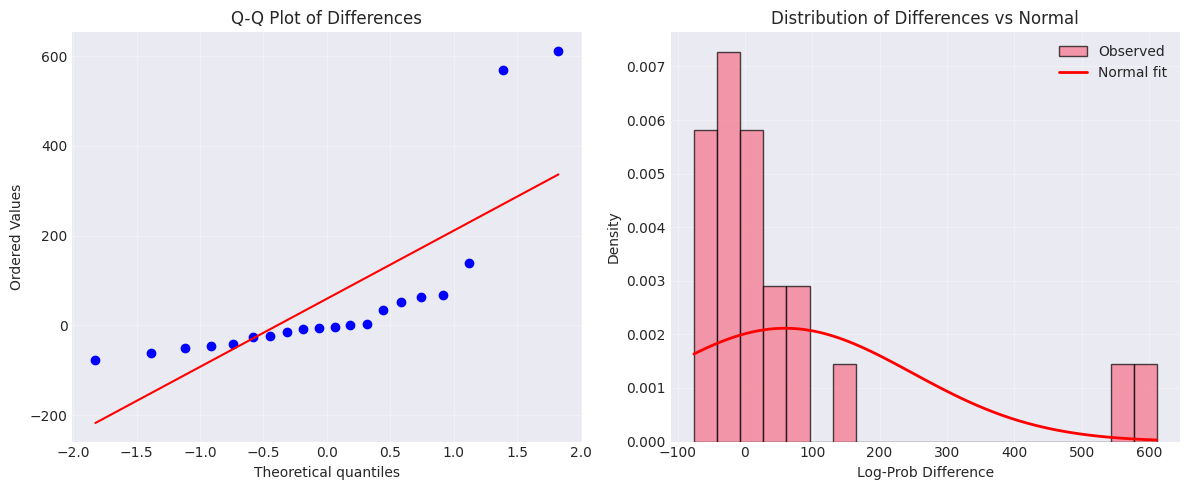

In [14]:
# Check for normality of differences (to justify using Wilcoxon over t-test)
print("\n" + "="*80)
print("TESTING ASSUMPTIONS")
print("="*80)

# Shapiro-Wilk test for normality
stat_shapiro, p_shapiro = shapiro(df_summary['log_prob_diff'])
print(f"\nShapiro-Wilk Test for Normality of Differences:")
print(f"  Test statistic: {stat_shapiro:.4f}")
print(f"  p-value: {p_shapiro:.4f}")
if p_shapiro < CONFIG['alpha']:
    print(f"  → Reject normality (p < {CONFIG['alpha']}): Wilcoxon test is appropriate")
else:
    print(f"  → Cannot reject normality (p >= {CONFIG['alpha']}): Both tests could be used")

# Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot
stats.probplot(df_summary['log_prob_diff'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot of Differences')
axes[0].grid(True, alpha=0.3)

# Histogram with normal overlay
axes[1].hist(df_summary['log_prob_diff'], bins=20, density=True,
             edgecolor='black', alpha=0.7, label='Observed')
mu, std = df_summary['log_prob_diff'].mean(), df_summary['log_prob_diff'].std()
x = np.linspace(df_summary['log_prob_diff'].min(), df_summary['log_prob_diff'].max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label='Normal fit')
axes[1].set_xlabel('Log-Prob Difference')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Differences vs Normal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'normality_check.png'), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Perform Wilcoxon signed-rank test
print("\n" + "="*80)
print("WILCOXON SIGNED RANK TEST")
print("="*80)

# Two-tailed test
statistic, p_value = wilcoxon(
    df_summary['mcmc_cumulative_log_prob'],
    df_summary['std_cumulative_log_prob'],
    alternative='two-sided'
)

print(f"\nTwo-Tailed Test:")
print(f"  H₀: median(MCMC - Standard) = 0")
print(f"  H₁: median(MCMC - Standard) ≠ 0")
print(f"  Test statistic (W): {statistic:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significance level (α): {CONFIG['alpha']}")

if p_value < CONFIG['alpha']:
    print(f"  ✓ REJECT H₀: Significant difference detected (p < {CONFIG['alpha']})")
else:
    print(f"  ✗ FAIL TO REJECT H₀: No significant difference (p >= {CONFIG['alpha']})")

# One-tailed test (MCMC > Standard)
statistic_gt, p_value_gt = wilcoxon(
    df_summary['mcmc_cumulative_log_prob'],
    df_summary['std_cumulative_log_prob'],
    alternative='greater'
)

print(f"\nOne-Tailed Test (MCMC > Standard):")
print(f"  H₀: median(MCMC - Standard) ≤ 0")
print(f"  H₁: median(MCMC - Standard) > 0")
print(f"  Test statistic (W): {statistic_gt:.4f}")
print(f"  p-value: {p_value_gt:.6f}")

if p_value_gt < CONFIG['alpha']:
    print(f"  ✓ REJECT H₀: MCMC significantly better (p < {CONFIG['alpha']})")
else:
    print(f"  ✗ FAIL TO REJECT H₀: MCMC not significantly better (p >= {CONFIG['alpha']})")

# Effect size (rank-biserial correlation)
n = len(df_summary)
r = 1 - (4 * statistic) / (n * (n + 1))
print(f"\nEffect Size (rank-biserial correlation r):")
print(f"  r = {r:.4f}")
print(f"  Interpretation: ", end="")
if abs(r) < 0.1:
    print("Negligible")
elif abs(r) < 0.3:
    print("Small")
elif abs(r) < 0.5:
    print("Medium")
else:
    print("Large")


WILCOXON SIGNED RANK TEST

Two-Tailed Test:
  H₀: median(MCMC - Standard) = 0
  H₁: median(MCMC - Standard) ≠ 0
  Test statistic (W): 97.0000
  p-value: 0.784126
  Significance level (α): 0.05
  ✗ FAIL TO REJECT H₀: No significant difference (p >= 0.05)

One-Tailed Test (MCMC > Standard):
  H₀: median(MCMC - Standard) ≤ 0
  H₁: median(MCMC - Standard) > 0
  Test statistic (W): 113.0000
  p-value: 0.392063
  ✗ FAIL TO REJECT H₀: MCMC not significantly better (p >= 0.05)

Effect Size (rank-biserial correlation r):
  r = 0.0762
  Interpretation: Negligible


In [16]:
# Compare with paired t-test for reference
print("\n" + "="*80)
print("PAIRED T-TEST (FOR COMPARISON)")
print("="*80)

t_stat, t_pvalue = stats.ttest_rel(
    df_summary['mcmc_cumulative_log_prob'],
    df_summary['std_cumulative_log_prob']
)

print(f"\nPaired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_pvalue:.6f}")

if t_pvalue < CONFIG['alpha']:
    print(f"  ✓ REJECT H₀ (p < {CONFIG['alpha']})")
else:
    print(f"  ✗ FAIL TO REJECT H₀ (p >= {CONFIG['alpha']})")

# Cohen's d effect size
cohens_d = df_summary['log_prob_diff'].mean() / df_summary['log_prob_diff'].std()
print(f"\nCohen's d: {cohens_d:.4f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small")
elif abs(cohens_d) < 0.5:
    print("Medium")
elif abs(cohens_d) < 0.8:
    print("Large")
else:
    print("Very Large")


PAIRED T-TEST (FOR COMPARISON)

Paired t-test:
  t-statistic: 1.4131
  p-value: 0.173797
  ✗ FAIL TO REJECT H₀ (p >= 0.05)

Cohen's d: 0.3160
  Interpretation: Medium


## 7. Statistical Power Analysis

### Type I and Type II Errors

- **Type I Error (α)**: False positive - rejecting H₀ when it's true
  - Probability of concluding there's a difference when there isn't
  - Controlled by significance level (typically 0.05)

- **Type II Error (β)**: False negative - failing to reject H₀ when it's false
  - Probability of missing a real difference
  
- **Statistical Power (1-β)**: Probability of correctly rejecting H₀ when it's false
  - Power of 0.8 (80%) is typically considered adequate

### Power Analysis via Simulation

We'll simulate the power of the Wilcoxon test under different scenarios.

In [17]:
def simulate_type_i_error(n_samples, n_simulations=1000, alpha=0.05):
    """
    Simulate Type I error rate under null hypothesis.

    Under H₀, both samples come from the same distribution.
    We should reject H₀ only α% of the time.
    """
    rejections = 0

    for _ in range(n_simulations):
        # Generate paired samples from same distribution (H₀ is true)
        sample1 = np.random.normal(0, 1, n_samples)
        sample2 = np.random.normal(0, 1, n_samples)  # Same distribution

        # Wilcoxon test
        _, p_value = wilcoxon(sample1, sample2, alternative='two-sided')

        if p_value < alpha:
            rejections += 1

    type_i_error_rate = rejections / n_simulations
    return type_i_error_rate


def simulate_power(n_samples, effect_size, n_simulations=1000, alpha=0.05):
    """
    Simulate statistical power under alternative hypothesis.

    Under H₁, samples come from different distributions.
    Power is the probability of correctly rejecting H₀.

    Args:
        effect_size: Mean difference in standard deviations (Cohen's d)
    """
    rejections = 0

    for _ in range(n_simulations):
        # Generate paired samples with true difference (H₁ is true)
        sample1 = np.random.normal(0, 1, n_samples)
        sample2 = np.random.normal(effect_size, 1, n_samples)  # Shifted by effect_size

        # Wilcoxon test
        _, p_value = wilcoxon(sample1, sample2, alternative='two-sided')

        if p_value < alpha:
            rejections += 1

    power = rejections / n_simulations
    return power


def simulate_type_ii_error(n_samples, effect_size, n_simulations=1000, alpha=0.05):
    """
    Simulate Type II error rate under alternative hypothesis.

    Type II error = 1 - Power
    """
    power = simulate_power(n_samples, effect_size, n_simulations, alpha)
    return 1 - power

In [18]:
# Simulate Type I error
print("\n" + "="*80)
print("TYPE I ERROR SIMULATION")
print("="*80)

n_sims = 1000
sample_size = len(df_summary)

print(f"\nSimulating {n_sims} tests under H₀ (no true difference)...")
type_i_error = simulate_type_i_error(sample_size, n_sims, CONFIG['alpha'])

print(f"\nResults:")
print(f"  Nominal α (significance level): {CONFIG['alpha']:.3f}")
print(f"  Simulated Type I error rate: {type_i_error:.3f}")
print(f"  Expected rejections: {CONFIG['alpha'] * n_sims:.0f}")
print(f"  Actual rejections: {type_i_error * n_sims:.0f}")

if abs(type_i_error - CONFIG['alpha']) < 0.02:  # Within 2%
    print(f"  ✓ Type I error rate matches nominal α")
else:
    print(f"  ⚠ Type I error rate differs from nominal α (may be due to sampling variation)")


TYPE I ERROR SIMULATION

Simulating 1000 tests under H₀ (no true difference)...

Results:
  Nominal α (significance level): 0.050
  Simulated Type I error rate: 0.048
  Expected rejections: 50
  Actual rejections: 48
  ✓ Type I error rate matches nominal α



STATISTICAL POWER ANALYSIS

Simulating power across effect sizes (n=20, α=0.05)...


Effect sizes:   0%|          | 0/16 [00:00<?, ?it/s]

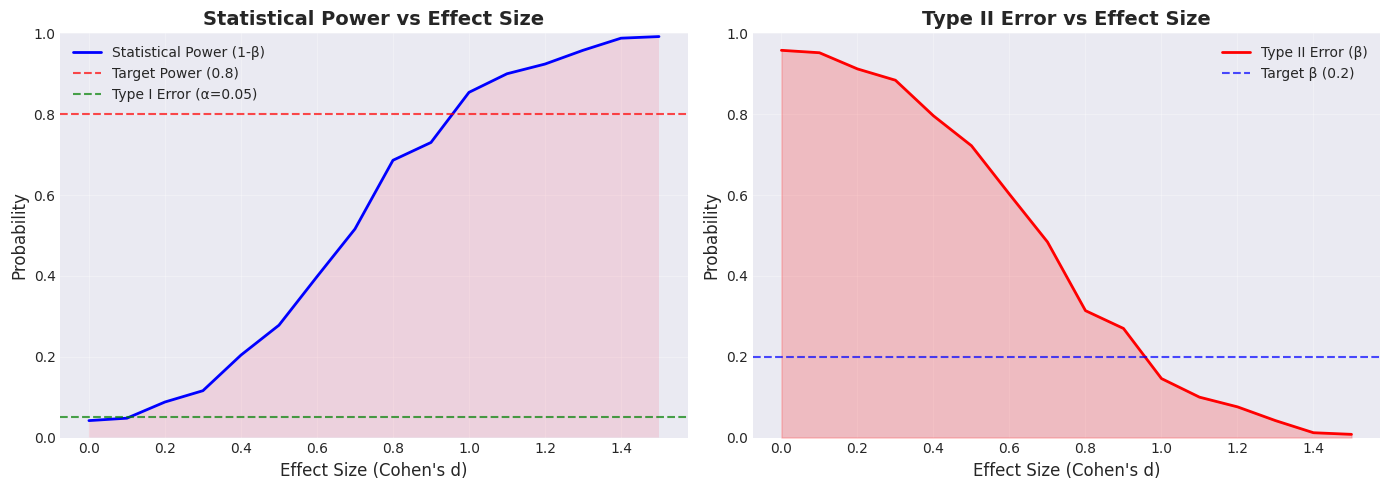


Key Findings:
  Sample size: n = 20
  Minimum Detectable Effect (80% power): d ≈ 1.000
  Observed effect size in our data: d = 0.316
  ⚠ Our study may be underpowered for the observed effect size


In [19]:
# Power analysis across different effect sizes
print("\n" + "="*80)
print("STATISTICAL POWER ANALYSIS")
print("="*80)

effect_sizes = np.linspace(0, 1.5, 16)  # Cohen's d from 0 to 1.5
powers = []
type_ii_errors = []

print(f"\nSimulating power across effect sizes (n={sample_size}, α={CONFIG['alpha']})...")
for es in tqdm(effect_sizes, desc="Effect sizes"):
    power = simulate_power(sample_size, es, n_simulations=500, alpha=CONFIG['alpha'])
    powers.append(power)
    type_ii_errors.append(1 - power)

# Plot power curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Power curve
axes[0].plot(effect_sizes, powers, 'b-', linewidth=2, label='Statistical Power (1-β)')
axes[0].axhline(y=0.8, color='r', linestyle='--', label='Target Power (0.8)', alpha=0.7)
axes[0].axhline(y=CONFIG['alpha'], color='g', linestyle='--',
                label=f'Type I Error (α={CONFIG["alpha"]})', alpha=0.7)
axes[0].fill_between(effect_sizes, 0, powers, alpha=0.2)
axes[0].set_xlabel('Effect Size (Cohen\'s d)', fontsize=12)
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_title('Statistical Power vs Effect Size', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Type II error curve
axes[1].plot(effect_sizes, type_ii_errors, 'r-', linewidth=2, label='Type II Error (β)')
axes[1].axhline(y=0.2, color='b', linestyle='--', label='Target β (0.2)', alpha=0.7)
axes[1].fill_between(effect_sizes, 0, type_ii_errors, alpha=0.2, color='red')
axes[1].set_xlabel('Effect Size (Cohen\'s d)', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Type II Error vs Effect Size', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'power_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Find minimum detectable effect size for 80% power
target_power = 0.8
idx_80 = np.argmin(np.abs(np.array(powers) - target_power))
mde = effect_sizes[idx_80]

print(f"\nKey Findings:")
print(f"  Sample size: n = {sample_size}")
print(f"  Minimum Detectable Effect (80% power): d ≈ {mde:.3f}")
print(f"  Observed effect size in our data: d = {cohens_d:.3f}")

if abs(cohens_d) >= mde:
    print(f"  ✓ Our study has sufficient power to detect the observed effect")
else:
    print(f"  ⚠ Our study may be underpowered for the observed effect size")


SAMPLE SIZE REQUIREMENTS


Effect size d=0.2:   0%|          | 0/8 [00:00<?, ?it/s]

Effect size d=0.5:   0%|          | 0/8 [00:00<?, ?it/s]

Effect size d=0.8:   0%|          | 0/8 [00:00<?, ?it/s]

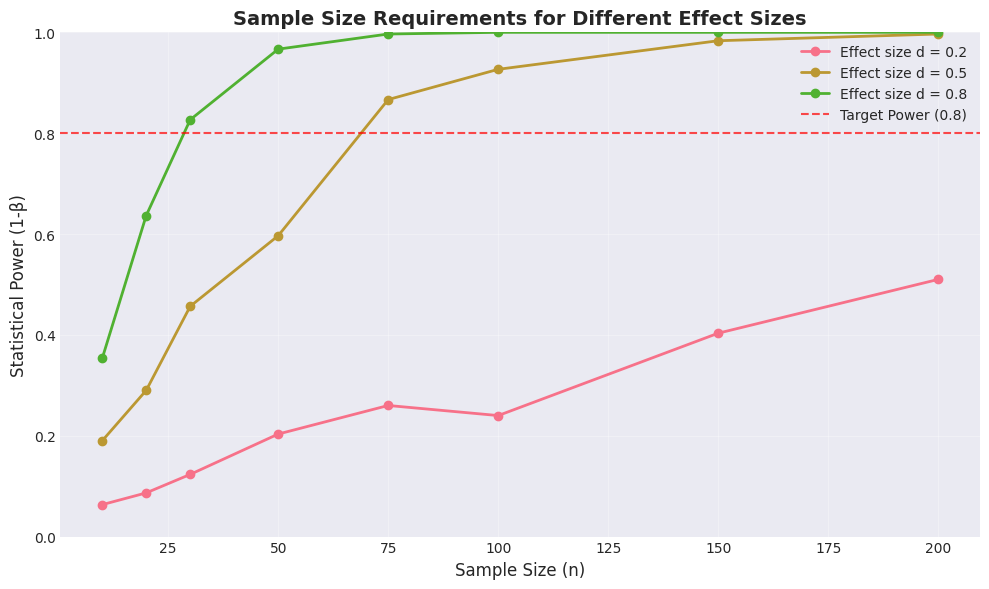


Sample Size Recommendations (for 80% power, α=0.05):
  Effect size d = 0.2: n > 200 (need larger sample)
  Effect size d = 0.5: n ≥ 75
  Effect size d = 0.8: n ≥ 30


In [20]:
# Sample size analysis: How many samples needed for different effect sizes?
print("\n" + "="*80)
print("SAMPLE SIZE REQUIREMENTS")
print("="*80)

target_effect_sizes = [0.2, 0.5, 0.8]  # Small, medium, large
sample_sizes = [10, 20, 30, 50, 75, 100, 150, 200]

power_results = {}
for es in target_effect_sizes:
    powers_for_es = []
    for n in tqdm(sample_sizes, desc=f"Effect size d={es}", leave=False):
        power = simulate_power(n, es, n_simulations=300, alpha=CONFIG['alpha'])
        powers_for_es.append(power)
    power_results[es] = powers_for_es

# Plot sample size requirements
plt.figure(figsize=(10, 6))
for es, powers_list in power_results.items():
    plt.plot(sample_sizes, powers_list, marker='o', linewidth=2,
             label=f'Effect size d = {es}')

plt.axhline(y=0.8, color='r', linestyle='--', label='Target Power (0.8)', alpha=0.7)
plt.xlabel('Sample Size (n)', fontsize=12)
plt.ylabel('Statistical Power (1-β)', fontsize=12)
plt.title('Sample Size Requirements for Different Effect Sizes', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'sample_size_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSample Size Recommendations (for 80% power, α={CONFIG['alpha']}):")
for es in target_effect_sizes:
    powers_list = power_results[es]
    # Find minimum sample size for 80% power
    for i, (n, p) in enumerate(zip(sample_sizes, powers_list)):
        if p >= 0.8:
            print(f"  Effect size d = {es:.1f}: n ≥ {n}")
            break
    else:
        print(f"  Effect size d = {es:.1f}: n > {sample_sizes[-1]} (need larger sample)")

## 8. Detailed Per-Question Analysis

In [21]:
# Create detailed results table
detailed_results = pd.DataFrame([
    {
        'Q_ID': r['question_idx'],
        'Question': r['question'][:50] + '...',
        'Std_LogProb': r['std_cumulative_log_prob'],
        'MCMC_LogProb': r['mcmc_cumulative_log_prob'],
        'Diff': r['mcmc_cumulative_log_prob'] - r['std_cumulative_log_prob'],
        'Std_Tokens': r['std_num_tokens'],
        'MCMC_Tokens': r['mcmc_num_tokens'],
        'Std_Correct': '✓' if r['std_correct'] else '✗',
        'MCMC_Correct': '✓' if r['mcmc_correct'] else '✗',
        'MCMC_AcceptRatio': r['mcmc_acceptance_ratio'],
    }
    for r in results
])

print("\n" + "="*80)
print("DETAILED PER-QUESTION RESULTS")
print("="*80)
print(detailed_results.to_string(index=False))

# Save to CSV
detailed_results.to_csv(
    os.path.join(CONFIG['save_dir'], 'detailed_results.csv'),
    index=False
)
print(f"\nSaved detailed results to {os.path.join(CONFIG['save_dir'], 'detailed_results.csv')}")


DETAILED PER-QUESTION RESULTS
 Q_ID                                               Question  Std_LogProb  MCMC_LogProb       Diff  Std_Tokens  MCMC_Tokens Std_Correct MCMC_Correct  MCMC_AcceptRatio
    0  Convert the point $(0,3)$ in rectangular coordinat...   -47.317440    -50.385065  -3.067625         476          332           ✗            ✗          0.500000
    1 Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2} \qu...  -778.827373   -167.136233 611.691141        1219          909           ✗            ✓          0.316667
    2  If $f(x) = \frac{3x-2}{x-2}$, what is the value of...   -95.739617    -27.523140  68.216477         439          486           ✗            ✓          0.800000
    3  How many positive whole-number divisors does 196 h...   -68.352975    -33.974631  34.378344         210          551           ✓            ✓          0.675000
    4  The results of a cross-country team's training run...  -142.382279    -77.996898  64.385381         475          467           

## 9. Summary Report

In [22]:
# Generate comprehensive summary report
report = f"""
{'='*80}
WILCOXON SIGNED RANK TEST: MCMC vs STANDARD SAMPLING
COMPREHENSIVE STATISTICAL ANALYSIS REPORT
{'='*80}

1. EXPERIMENT CONFIGURATION
{'-'*80}
Model: {CONFIG['model']} ({CONFIG['model_str']})
Dataset: MATH500
Questions analyzed: {len(results)}
Temperature: {CONFIG['temperature']}
MCMC steps: {CONFIG['mcmc_steps']}
Significance level (α): {CONFIG['alpha']}

2. DESCRIPTIVE STATISTICS
{'-'*80}
Standard Sampling:
  Mean cumulative log-prob: {df_summary['std_cumulative_log_prob'].mean():.4f} ± {df_summary['std_cumulative_log_prob'].std():.4f}
  Mean tokens: {df_summary['std_num_tokens'].mean():.2f}
  Accuracy: {df_summary['std_correct'].mean():.2%} ({df_summary['std_correct'].sum()}/{len(df_summary)})

MCMC Sampling:
  Mean cumulative log-prob: {df_summary['mcmc_cumulative_log_prob'].mean():.4f} ± {df_summary['mcmc_cumulative_log_prob'].std():.4f}
  Mean tokens: {df_summary['mcmc_num_tokens'].mean():.2f}
  Accuracy: {df_summary['mcmc_correct'].mean():.2%} ({df_summary['mcmc_correct'].sum()}/{len(df_summary)})
  Mean acceptance ratio: {df_summary['mcmc_acceptance_ratio'].mean():.4f}

Difference (MCMC - Standard):
  Mean difference: {df_summary['log_prob_diff'].mean():.4f}
  Median difference: {df_summary['log_prob_diff'].median():.4f}
  Std difference: {df_summary['log_prob_diff'].std():.4f}

3. WILCOXON SIGNED RANK TEST RESULTS
{'-'*80}
Two-tailed test:
  H₀: median(MCMC - Standard) = 0
  H₁: median(MCMC - Standard) ≠ 0

  Test statistic (W): {statistic:.4f}
  p-value: {p_value:.6f}
  Decision: {'REJECT H₀' if p_value < CONFIG['alpha'] else 'FAIL TO REJECT H₀'}

  Effect size (rank-biserial r): {r:.4f}
  Interpretation: {'Negligible' if abs(r) < 0.1 else 'Small' if abs(r) < 0.3 else 'Medium' if abs(r) < 0.5 else 'Large'}

One-tailed test (MCMC > Standard):
  p-value: {p_value_gt:.6f}
  Decision: {'REJECT H₀' if p_value_gt < CONFIG['alpha'] else 'FAIL TO REJECT H₀'}

4. PAIRED T-TEST (PARAMETRIC COMPARISON)
{'-'*80}
  t-statistic: {t_stat:.4f}
  p-value: {t_pvalue:.6f}
  Decision: {'REJECT H₀' if t_pvalue < CONFIG['alpha'] else 'FAIL TO REJECT H₀'}

  Cohen's d: {cohens_d:.4f}
  Interpretation: {'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}

5. NORMALITY ASSESSMENT
{'-'*80}
Shapiro-Wilk test:
  Test statistic: {stat_shapiro:.4f}
  p-value: {p_shapiro:.4f}
  Conclusion: {'Non-normal distribution (Wilcoxon preferred)' if p_shapiro < CONFIG['alpha'] else 'Cannot reject normality'}

6. POWER ANALYSIS
{'-'*80}
Type I Error Simulation:
  Nominal α: {CONFIG['alpha']:.3f}
  Simulated Type I error: {type_i_error:.3f}
  Status: {'✓ Matches nominal α' if abs(type_i_error - CONFIG['alpha']) < 0.02 else '⚠ Differs from nominal α'}

Statistical Power:
  Sample size: n = {sample_size}
  Observed effect size: d = {cohens_d:.3f}
  Minimum detectable effect (80% power): d ≈ {mde:.3f}

  Study power assessment: {'✓ Sufficient power' if abs(cohens_d) >= mde else '⚠ May be underpowered'}

7. CONCLUSIONS
{'-'*80}
Based on the Wilcoxon signed rank test with {len(results)} paired observations:

• Statistical Significance: {'Significant difference detected (p < α)' if p_value < CONFIG['alpha'] else 'No significant difference detected (p ≥ α)'}
• Effect Size: {abs(r):.3f} ({'negligible' if abs(r) < 0.1 else 'small' if abs(r) < 0.3 else 'medium' if abs(r) < 0.5 else 'large'})
• Practical Significance: Mean log-prob {'improvement' if df_summary['log_prob_diff'].mean() > 0 else 'decrease'} of {abs(df_summary['log_prob_diff'].mean()):.4f}
• Accuracy Impact: {'MCMC shows higher accuracy' if df_summary['mcmc_correct'].mean() > df_summary['std_correct'].mean() else 'Standard shows higher accuracy' if df_summary['std_correct'].mean() > df_summary['mcmc_correct'].mean() else 'Similar accuracy'}

Recommendation:
{('MCMC sampling shows statistically significant improvement in log-probabilities.' if p_value < CONFIG['alpha'] and df_summary['log_prob_diff'].mean() > 0 else 'Standard sampling shows statistically significant improvement in log-probabilities.' if p_value < CONFIG['alpha'] and df_summary['log_prob_diff'].mean() < 0 else 'No significant difference between methods. Choice may depend on computational cost vs. benefit.')}

{'='*80}
END OF REPORT
{'='*80}
"""

print(report)

# Save report
report_file = os.path.join(CONFIG['save_dir'], 'wilcoxon_test_report.txt')
with open(report_file, 'w') as f:
    f.write(report)

print(f"\nReport saved to: {report_file}")


WILCOXON SIGNED RANK TEST: MCMC vs STANDARD SAMPLING
COMPREHENSIVE STATISTICAL ANALYSIS REPORT

1. EXPERIMENT CONFIGURATION
--------------------------------------------------------------------------------
Model: qwen_math (Qwen/Qwen2.5-Math-7B)
Dataset: MATH500
Questions analyzed: 20
Temperature: 0.25
MCMC steps: 10
Significance level (α): 0.05

2. DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
Standard Sampling:
  Mean cumulative log-prob: -148.2475 ± 215.0490
  Mean tokens: 608.30
  Accuracy: 45.00% (9/20)

MCMC Sampling:
  Mean cumulative log-prob: -88.6324 ± 58.0246
  Mean tokens: 533.95
  Accuracy: 70.00% (14/20)
  Mean acceptance ratio: 0.5557

Difference (MCMC - Standard):
  Mean difference: 59.6151
  Median difference: -4.4981
  Std difference: 188.6667

3. WILCOXON SIGNED RANK TEST RESULTS
--------------------------------------------------------------------------------
Two-tailed test:
  H₀: median(MCMC - Standard) = 0


## 10. Additional Analyses


TOKEN-LEVEL ANALYSIS

Total tokens analyzed:
  Standard: 12166
  MCMC: 10679

Per-token statistics:
  Standard - Mean: -0.2437, Std: 0.7361
  MCMC - Mean: -0.1660, Std: 0.6047


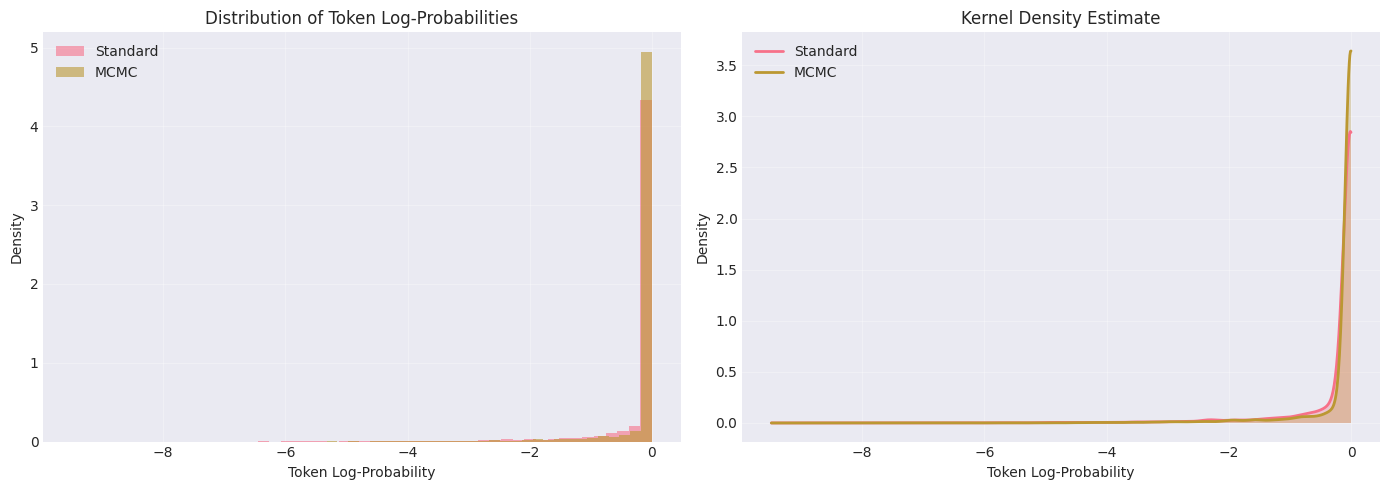

In [23]:
# Analyze token-level log probabilities
print("\n" + "="*80)
print("TOKEN-LEVEL ANALYSIS")
print("="*80)

# Aggregate all token log probs
all_std_token_logprobs = []
all_mcmc_token_logprobs = []

for r in results:
    all_std_token_logprobs.extend(r['std_log_probs'])
    all_mcmc_token_logprobs.extend(r['mcmc_log_probs'])

print(f"\nTotal tokens analyzed:")
print(f"  Standard: {len(all_std_token_logprobs)}")
print(f"  MCMC: {len(all_mcmc_token_logprobs)}")

print(f"\nPer-token statistics:")
print(f"  Standard - Mean: {np.mean(all_std_token_logprobs):.4f}, Std: {np.std(all_std_token_logprobs):.4f}")
print(f"  MCMC - Mean: {np.mean(all_mcmc_token_logprobs):.4f}, Std: {np.std(all_mcmc_token_logprobs):.4f}")

# Distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograms
axes[0].hist(all_std_token_logprobs, bins=50, alpha=0.6, label='Standard', density=True)
axes[0].hist(all_mcmc_token_logprobs, bins=50, alpha=0.6, label='MCMC', density=True)
axes[0].set_xlabel('Token Log-Probability')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Token Log-Probabilities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# KDE plots
from scipy.stats import gaussian_kde
kde_std = gaussian_kde(all_std_token_logprobs)
kde_mcmc = gaussian_kde(all_mcmc_token_logprobs)
x_range = np.linspace(
    min(min(all_std_token_logprobs), min(all_mcmc_token_logprobs)),
    max(max(all_std_token_logprobs), max(all_mcmc_token_logprobs)),
    1000
)
axes[1].plot(x_range, kde_std(x_range), label='Standard', linewidth=2)
axes[1].plot(x_range, kde_mcmc(x_range), label='MCMC', linewidth=2)
axes[1].fill_between(x_range, kde_std(x_range), alpha=0.3)
axes[1].fill_between(x_range, kde_mcmc(x_range), alpha=0.3)
axes[1].set_xlabel('Token Log-Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Kernel Density Estimate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'token_level_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

## 11. Export Data for Further Analysis

In [24]:
# Export summary statistics
summary_stats = {
    'config': CONFIG,
    'sample_size': len(results),
    'wilcoxon_test': {
        'two_tailed': {
            'statistic': float(statistic),
            'p_value': float(p_value),
            'effect_size_r': float(r),
        },
        'one_tailed_greater': {
            'statistic': float(statistic_gt),
            'p_value': float(p_value_gt),
        },
    },
    'paired_ttest': {
        't_statistic': float(t_stat),
        'p_value': float(t_pvalue),
        'cohens_d': float(cohens_d),
    },
    'normality_test': {
        'shapiro_statistic': float(stat_shapiro),
        'shapiro_p_value': float(p_shapiro),
    },
    'power_analysis': {
        'type_i_error': float(type_i_error),
        'minimum_detectable_effect': float(mde),
    },
    'descriptive_stats': {
        'standard': {
            'mean_cumulative_logprob': float(df_summary['std_cumulative_log_prob'].mean()),
            'std_cumulative_logprob': float(df_summary['std_cumulative_log_prob'].std()),
            'mean_tokens': float(df_summary['std_num_tokens'].mean()),
            'accuracy': float(df_summary['std_correct'].mean()),
        },
        'mcmc': {
            'mean_cumulative_logprob': float(df_summary['mcmc_cumulative_log_prob'].mean()),
            'std_cumulative_logprob': float(df_summary['mcmc_cumulative_log_prob'].std()),
            'mean_tokens': float(df_summary['mcmc_num_tokens'].mean()),
            'accuracy': float(df_summary['mcmc_correct'].mean()),
            'mean_acceptance_ratio': float(df_summary['mcmc_acceptance_ratio'].mean()),
        },
    },
}

stats_file = os.path.join(CONFIG['save_dir'], 'summary_statistics.json')
with open(stats_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"Summary statistics saved to: {stats_file}")

# Export DataFrame
df_file = os.path.join(CONFIG['save_dir'], 'analysis_dataframe.csv')
df_summary.to_csv(df_file, index=False)
print(f"Analysis dataframe saved to: {df_file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {CONFIG['save_dir']}")
print("\nGenerated files:")
for filename in os.listdir(CONFIG['save_dir']):
    filepath = os.path.join(CONFIG['save_dir'], filename)
    if os.path.isfile(filepath):
        size = os.path.getsize(filepath)
        print(f"  - {filename} ({size:,} bytes)")

TypeError: float() argument must be a string or a real number, not 'dict'